In [27]:
import os, json, math
import numpy as np
import pandas as pd
%matplotlib inline

libCBM related imports

In [28]:
from libcbmwrapper import LibCBMWrapper
import libcbmconfig
import cbm_defaults


cbm3 related imports

In [29]:
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import sit_helper
from cbm3_python.cbm3data import cbm3_results


scenario set-up

In [30]:
db_path = 'C:\dev\cbm_defaults\cbm_defaults.db'
n_steps = 225

age_interval = 10 #required by cbm3
num_age_classes = 20 #required by cbm3

def get_classifier_name(id):
    return str(id)

def create_growth_curve(id, admin_boundary, eco_boundary, softwood_species=None, 
                        softwood_age_volume_pairs=None, hardwood_species=None, 
                        hardwood_age_volume_pairs=None):
    return {
        "id":id,
        "admin_boundary": admin_boundary,
        "eco_boundary": eco_boundary,
        "softwood_species": softwood_species,
        "softwood_age_volume_pairs": softwood_age_volume_pairs,
        "hardwood_species": hardwood_species,
        "hardwood_age_volume_pairs": hardwood_age_volume_pairs
    }

def generate_random_yield(size, age_step, ndigits ):
    
    #return y for a single value of x: nx
    def get_impulse_func():
        y = np.random.rand(1)[0] * 500
        nx = round(np.random.rand(1)[0] * size)
        def impulse(x):
            if x==nx:
                return y
            else:
                return 0
        return impulse

    #return a step of value y for the range minx to maxX
    def get_step_func():
        y = np.random.rand(1)[0] * 500
        minX = round(np.random.rand(1)[0] * size)
        maxX = round(np.random.rand(1)[0] * (size-minX)) + minX
        def step(x):
            if x == 0:
                return 0
            if x>=minX and x<=maxX:
                return y
            else:
                return 0
        return step

    def get_ramp_func():
        rate = np.random.rand(1)[0] * 5
        def ramp(x):
            return x*rate
        return ramp

    def get_expCurve_func():
        yMax = np.random.rand(1)[0] * 500
        def expCurve(x):
            return yMax - math.exp(-x) * yMax
        return expCurve
    
    func = np.random.choice([get_impulse_func,get_step_func,get_ramp_func,get_expCurve_func],1)[0]()
    return [(x*age_step,round(func(x),2)) for x in range(0, size)]
        
    
def generate_cases(random_seed, num_curves, dbpath, ndigits):
    '''
    ndigits is here because the CBM-CFS3 toolbox rounds yield curve volumes to 2 decimal places
    '''
    np.random.seed(random_seed)
    
    stand_type = np.random.choice(["softwood_only", "hardwood_only", "mixed"], num_curves)
    
    species = cbm_defaults.load_species_reference(dbpath, "en-CA")
    sw_species = [x for x in species if species[x]["forest_type_id"]==1 and len(x)<50] #exclude species names that are too long for the project database schema
    hw_species = [x for x in species if species[x]["forest_type_id"]==3 and len(x)<50]
    
    
    random_sw_species = np.random.choice(list(sw_species), num_curves)
    random_hw_species = np.random.choice(list(hw_species), num_curves)
    
    spatial_units = cbm_defaults.get_spatial_unit_ids_by_admin_eco_name(dbpath, "en-CA")
    random_spus = np.random.choice([",".join(x) for x in spatial_units.keys()], num_curves)

    cases = []
    for i in range(num_curves):
        spu = random_spus[i].split(',')        
        cases.append(create_growth_curve(
            id = i+1,
            admin_boundary=spu[0],
            eco_boundary=spu[1],
            softwood_species = random_sw_species[i] if stand_type[i] in ["softwood_only", "mixed"] else None,
            softwood_age_volume_pairs = generate_random_yield(num_age_classes,age_interval, ndigits)
                if stand_type[i] in ["softwood_only", "mixed"] else None,
            hardwood_species = random_hw_species[i] if stand_type[i] in ["hardwood_only", "mixed"] else None,
            hardwood_age_volume_pairs = generate_random_yield(num_age_classes,age_interval, ndigits) 
                if stand_type[i] in ["hardwood_only", "mixed"] else None,           
             ))
    return cases

run test cases on libCBM

In [31]:
def run_libCBM(dbpath, cases, nsteps):
    
    dllpath = r'C:\dev\LibCBM\LibCBM\x64\Debug\LibCBM.dll'

    dlldir = os.path.dirname(dllpath)
    cwd = os.getcwd()
    os.chdir(dlldir)
    dll = LibCBMWrapper(dllpath)
    os.chdir(cwd)
    
    #create a single classifier/classifier value for the single growth curve
    classifiers_config = libcbmconfig.classifier_config([
        libcbmconfig.classifier("growth_curve", [
            libcbmconfig.classifier_value(get_classifier_name(c["id"])) 
            for c in cases
        ])
    ])


    transitions_config = []
    species_reference = cbm_defaults.load_species_reference(dbpath, "en-CA")
    spatial_unit_reference = cbm_defaults.get_spatial_unit_ids_by_admin_eco_name(dbpath, "en-CA")
    curves = []
    for c in cases:
        softwood_species_id = None
        softwood_age_volume_pairs = None
        hardwood_species_id = None
        hardwood_age_volume_pairs = None
        if c["softwood_species"]:
            softwood_species_id = species_reference[c["softwood_species"]]["species_id"]
            softwood_age_volume_pairs = c["softwood_age_volume_pairs"]
        if c["hardwood_species"]:
            hardwood_species_id = species_reference[c["hardwood_species"]]["species_id"]
            hardwood_age_volume_pairs = c["hardwood_age_volume_pairs"]

        curve = libcbmconfig.merch_volume_curve(
            classifier_set = [get_classifier_name(c["id"])],
            softwood_species_id = softwood_species_id,
            softwood_age_volume_pairs = softwood_age_volume_pairs,
            hardwood_species_id = hardwood_species_id,
            hardwood_age_volume_pairs = hardwood_age_volume_pairs)
        curves.append(curve)

    merch_volume_to_biomass_config = libcbmconfig.merch_volume_to_biomass_config(
        dbpath, curves)

    config = libcbmconfig.initialize_config(
        dbpath = dbpath,
        merch_volume_to_biomass = merch_volume_to_biomass_config,
        classifiers = classifiers_config,
        transitions = [])

    dll.Initialize(libcbmconfig.to_string(config))

    nstands = len(cases)
    age = np.zeros(nstands,dtype=np.int32)
    classifiers = np.zeros((nstands,1),dtype=np.int32)
    classifiers[:,0]=[classifiers_config["classifier_index"][0][get_classifier_name(c["id"])] for c in cases]
         
    spatial_units = np.array(
        [spatial_unit_reference[(c["admin_boundary"],c["eco_boundary"])]
            for c in cases],dtype=np.int32)

    pools = np.zeros((nstands,len(config["pools"])))
    pools[:,0] = 1.0

    op = dll.AllocateOp(nstands)

    result = pd.DataFrame()
    for i in range(0, nsteps):
        dll.GetMerchVolumeGrowthOps(
            op, 
            classifiers=classifiers,
            pools=pools,
            ages=age,
            spatial_units=spatial_units,
            last_dist_type=None,
            time_since_last_dist=None,
            growth_multipliers=None)

        #since growth in CBM3 is split into 2 phases per timestep, 
        #we need to apply the operation 2 times in order to match it
        dll.ComputePools([op, op], pools)

        iteration_result = pd.DataFrame({x["name"]: pools[:,x["index"]] for x in config["pools"]})
        iteration_result.insert(0, "age", age+1)
        iteration_result.reset_index(level=0, inplace=True)
        result = result.append(iteration_result)

        age += 1

    result = result.reset_index(drop=True)
    return result

run test cases on cbm-cfs3. uses [StandardImportToolPlugin](https://github.com/cat-cfs/StandardImportToolPlugin) and [cbm3-python](https://github.com/cat-cfs/cbm3_python) to automate cbm-cfs3 functionality

In [32]:
def run_CBM3(cases, age_interval, num_age_classes, nsteps):
    
    standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()
    
    toolbox_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3"
    
    #there is a bug fix in this version of cbm/makelist for growth incrment blips
    cbm_exe_path = r"M:\CBM Tools and Development\Builds\CBMBuilds\20190530_growth_increment_fix"
    
    cbm3_project_dir = os.path.join(toolbox_path, "Projects", "libcbm_growth_curve_testing")
    cbm3_project_path = os.path.join(cbm3_project_dir, "libcbm_growth_curve_testing.mdb")
    cbm3_results_db_path = os.path.join(cbm3_project_dir, "libcbm_growth_curve_testing_results.mdb")
    config_save_path = os.path.join(cbm3_project_dir, "libcbm_growth_curve_testing.json")
    sit_config = sit_helper.SITConfig(
        imported_project_path=cbm3_project_path,
        initialize_mapping=True
    )
    sit_config.data_config(
        age_class_size=age_interval,
        num_age_classes=num_age_classes,
        classifiers=["admin", "eco", "identifier", "species"])
    sit_config.set_admin_eco_mapping("admin","eco")
    sit_config.set_species_classifier("species")
    for c in cases:
        cset = [c["admin_boundary"], c["eco_boundary"], get_classifier_name(c["id"]), "Spruce"]
        sit_config.add_inventory(classifier_set=cset, area=1, age=0, unfccc_land_class=0,
                        historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
        if c["softwood_species"]:
            sit_config.add_yield(classifier_set=cset, 
                        leading_species_classifier_value=c["softwood_species"],
                        values=[x[1] for x in c["softwood_age_volume_pairs"]])
        if c["hardwood_species"]:
            sit_config.add_yield(classifier_set=cset, 
                        leading_species_classifier_value=c["hardwood_species"],
                        values=[x[1] for x in c["hardwood_age_volume_pairs"]])
    sit_config.add_event(
        classifier_set=["?","?","?","?"],
        disturbance_type="Wildfire",
        time_step=nsteps+1,
        target=1,
        target_type = "Area",
        sort = "SORT_BY_SW_AGE")
    sit_config.import_project(standard_import_tool_plugin_path, config_save_path)
    cbm3_python.simulation.projectsimulator.run(
        aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
        project_path=cbm3_project_path, 
        toolbox_installation_dir=toolbox_path,
        cbm_exe_path=cbm_exe_path,
        results_database_path = cbm3_results_db_path)
    return cbm3_results_db_path

generate randomized growth curve test cases

In [33]:
cases = generate_cases(random_seed=1, num_curves=500, dbpath=db_path, ndigits=2)

run the test cases on libCBM

In [34]:
libCBM_result = run_libCBM(db_path, cases, n_steps)
libCBM_result["identifier"] = (libCBM_result["index"]+1).apply(get_classifier_name)

run the test cases on cbm-cfs3

In [36]:
cbm3_results_db_path = run_CBM3(cases, age_interval, num_age_classes, n_steps)
cbm3_result = cbm3_results.load_pool_indicators(cbm3_results_db_path, classifier_set_grouping=True)
cbm3_result["age"] = cbm3_result["TimeStep"]

join the results for plotting

In [38]:

libCBM_biomass = libCBM_result[['identifier','age', 'SoftwoodMerch', 'SoftwoodFoliage', 
               'SoftwoodOther', 'SoftwoodCoarseRoots', 'SoftwoodFineRoots',
               'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
               'HardwoodCoarseRoots', 'HardwoodFineRoots']]

cbm3_biomass = cbm3_result[['identifier','age', 'Softwood Merchantable', 'Softwood Foliage',
             'Softwood Other', 'Softwood Coarse Roots', 'Softwood Fine Roots',
             'Hardwood Merchantable', 'Hardwood Foliage', 'Hardwood Other',
             'Hardwood Coarse Roots', 'Hardwood Fine Roots']]

#make column naming consistent
cbm3_biomass = cbm3_biomass.rename(columns = {
    'Softwood Merchantable': 'SoftwoodMerch',
    'Softwood Foliage': 'SoftwoodFoliage',
    'Softwood Other': 'SoftwoodOther',
    'Softwood Coarse Roots': 'SoftwoodCoarseRoots',
    'Softwood Fine Roots': 'SoftwoodFineRoots',
    'Hardwood Merchantable': 'HardwoodMerch',
    'Hardwood Foliage': 'HardwoodFoliage',
    'Hardwood Other': 'HardwoodOther',
    'Hardwood Coarse Roots': 'HardwoodCoarseRoots',
    'Hardwood Fine Roots': 'HardwoodFineRoots'})

merged = libCBM_biomass.merge(cbm3_biomass,
                              left_on=['identifier','age'],
                              right_on=['identifier','age'],
                              suffixes=("_libCBM","_cbm3"))

diff_colnames = []
cbm3_colnames = []
libCBM_colnames = []
merged["total_diff"]=0
#compute diffs row-by-row
for pool in ['SoftwoodMerch', 'SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots',
             'SoftwoodFineRoots','HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther',
             'HardwoodCoarseRoots', 'HardwoodFineRoots']:
    
    d = "{}_diff".format(pool)
    l = "{}_libCBM".format(pool)
    r = "{}_cbm3".format(pool)
    diff_colnames.append(d)
    cbm3_colnames.append(r)
    libCBM_colnames.append(l)
    merged[d] = (merged[l] - merged[r])
    merged["total_diff"]+=merged[d]
merged["total_diff"] = merged["total_diff"].abs()

plot the worst 20 differences

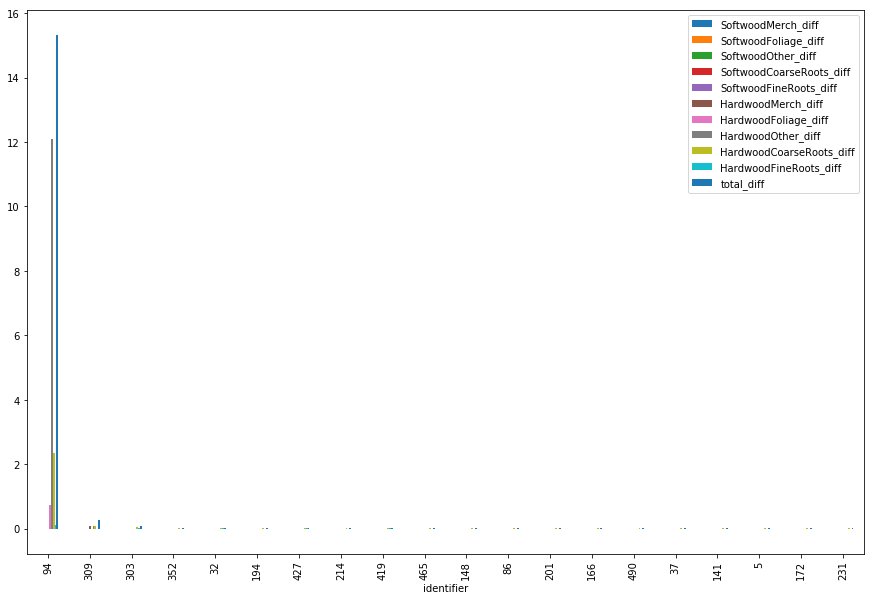

In [39]:
merged[["identifier"]+diff_colnames+["total_diff"]] \
    .groupby("identifier").sum() \
    .sort_values("total_diff", ascending=False) \
    .head(20) \
    .plot(figsize=(15,10), kind="bar")

plot a few of the worst cases for debugging

In [53]:
def plot_diff(id):
    markers = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]
    bio_pools = merged[merged["identifier"]==get_classifier_name(id)][["age"]+cbm3_colnames+libCBM_colnames] \
        .groupby("age").sum()
    ax = bio_pools.plot(figsize=(15,20), title=get_classifier_name(id))
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i%len(markers)])
    ax.legend(ax.get_lines(), bio_pools.columns, loc='best')
    merged[merged["identifier"]==get_classifier_name(id)][["age"]+diff_colnames].groupby("age").sum() \
        .plot(figsize=(15,10), title=get_classifier_name(id))

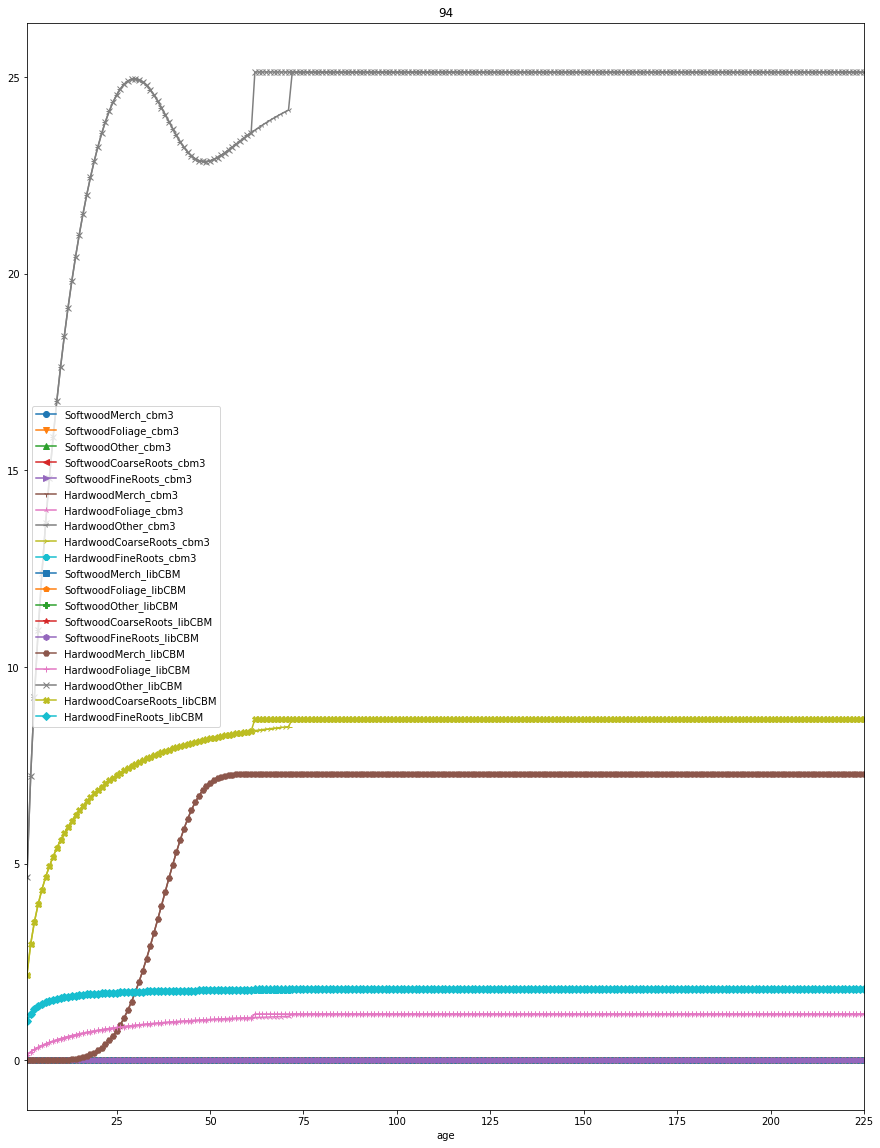

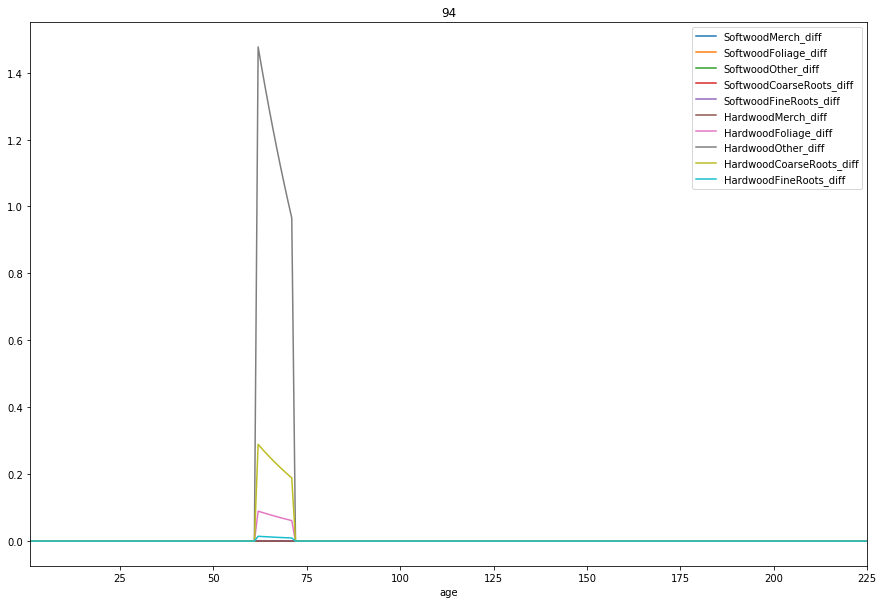

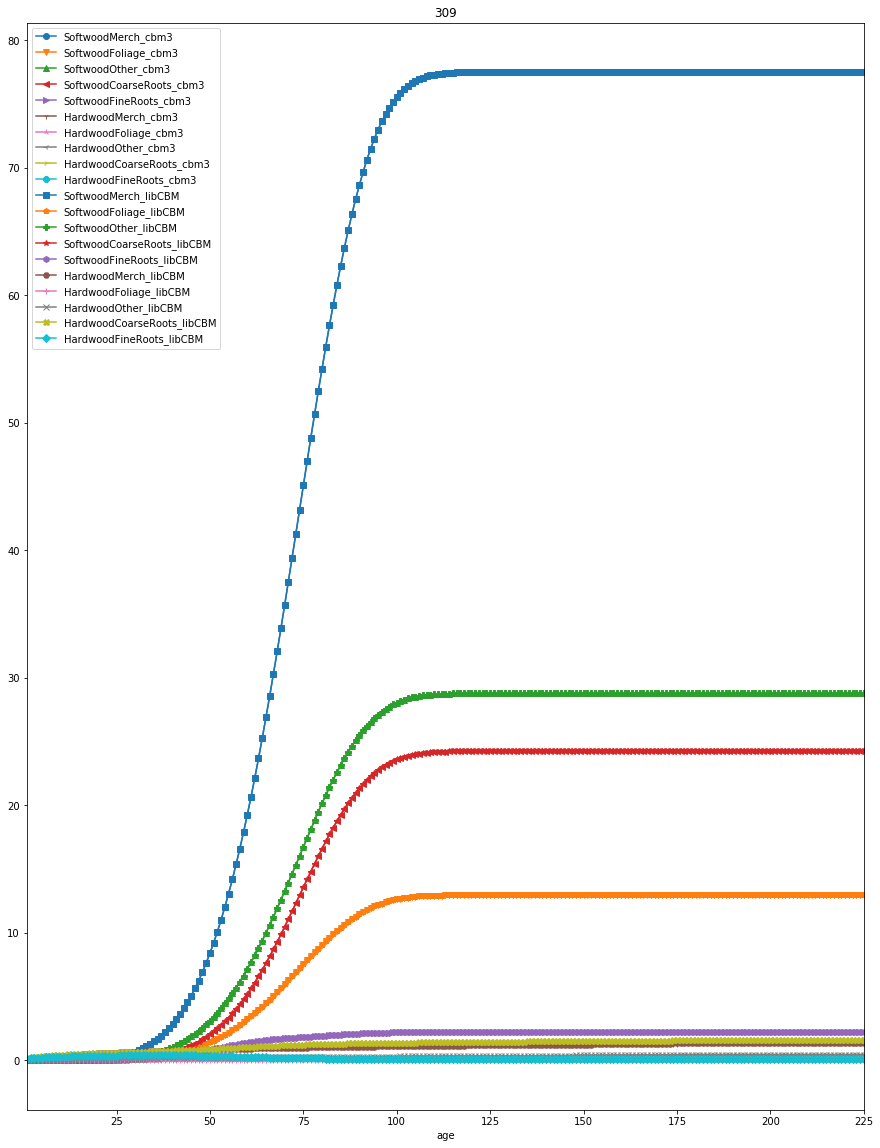

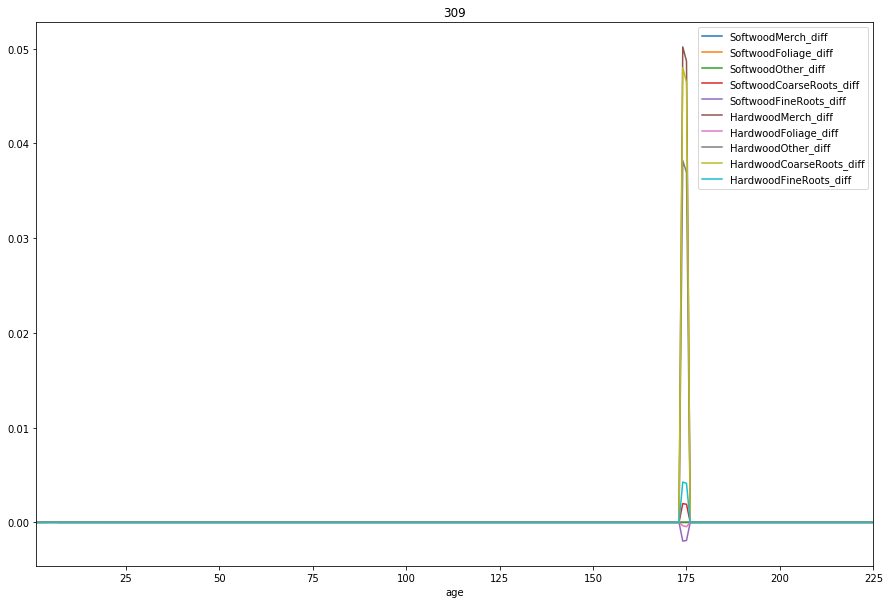

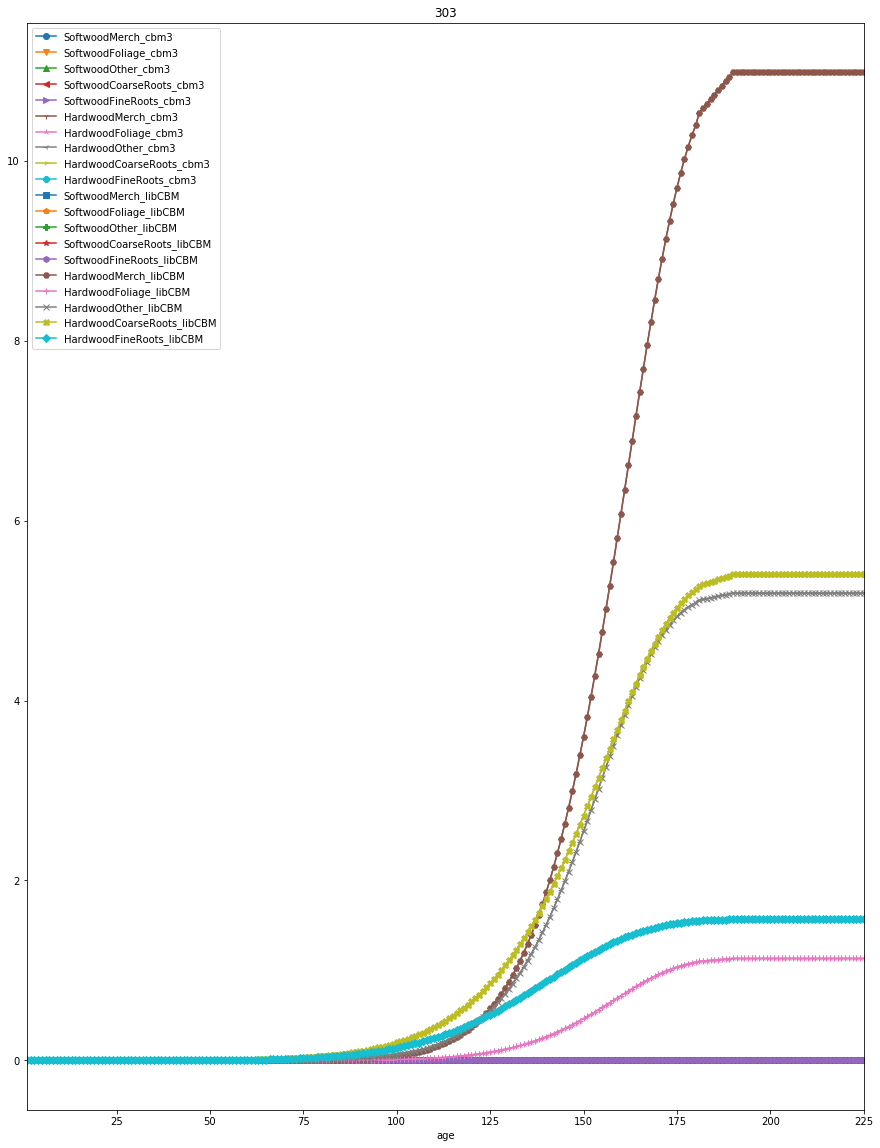

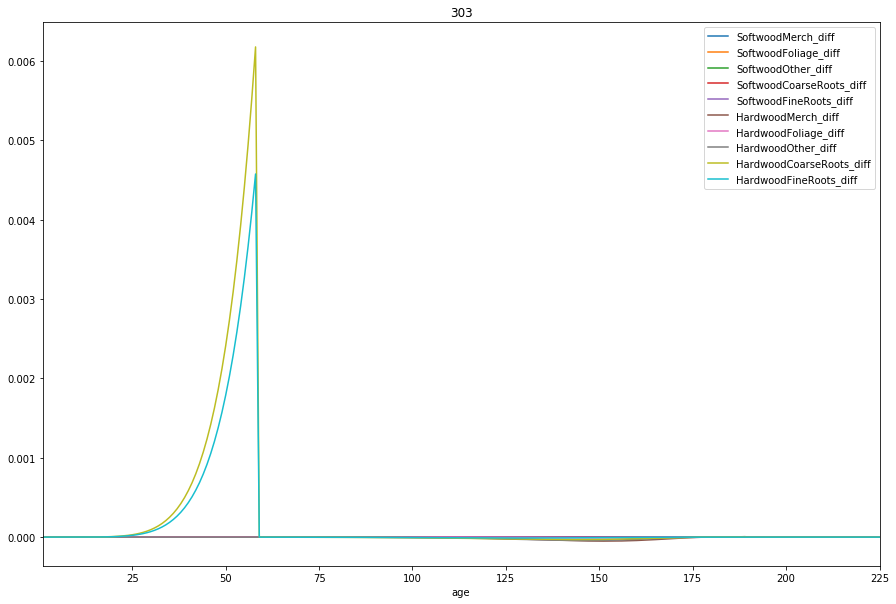

In [54]:
plot_diff(94)
plot_diff(309)
plot_diff(303)